# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import torchvision
from tqdm import tqdm_notebook as tqdm

In [2]:
from nets.simpleNet import simpleFCNet

In [3]:
torch.cuda.is_available()

True

# Load Data

In [4]:
mode = 'minibatch'

if mode == 'batch':
    batch_size = 60000
elif mode == 'minibatch':
    batch_size = 64
elif mode == 'sgd':
    batch_size = 1
    
test_batch_size = 64

In [5]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True, 
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))
                                                          ])),
                                           batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=False, download=True,
                                                         transform=transforms.Compose([
                                                             transforms.ToTensor(),
                                                             transforms.Normalize((0.1307,), (0.3081,))
                                                         ])),
                                          batch_size=test_batch_size, shuffle=True)

## Show some sample images

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


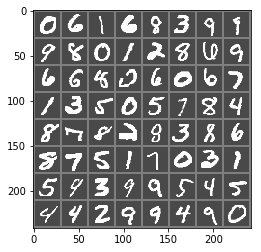

In [7]:
# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# Training and testing pipeline

In [8]:
def train(net, train_loader, criterion, optimizer, scheduler=None, num_epochs=10, verbose=False):
    losses = np.zeros(num_epochs)
    training_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        
        if scheduler is not None:
            scheduler.step()

        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

#             forward + backward + optimize
#             inputs = inputs.view(inputs.shape[0], -1)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses[epoch] += loss.item()
            running_loss += loss.item()            
            
            training_acc[epoch] += torch.sum(torch.argmax(outputs, dim=1)==labels).item()/train_loader.batch_size

#             if (i + 1)%200==0:
            if verbose:
                print('[%2d, %5d] loss: %f' %
                      (epoch + 1, i + 1, running_loss))
                running_loss = 0.0

    print('Finished Training')
    
    losses /= len(train_loader)
    training_acc /= len(train_loader)
    
    return losses, training_acc

In [9]:
def test(net, test_loader):
    test_acc = 0.0

    for i, data in enumerate(test_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         inputs = inputs.view(inputs.shape[0], -1)
        outputs = net(inputs)

        test_acc += torch.sum(torch.argmax(outputs, dim=1)==labels).item()/test_loader.batch_size
    
    test_acc /= len(test_loader)
    
    return test_acc

# Experiments with growing networks

In [34]:
learning_rate = 0.05

small_net = simpleFCNet(num_neurons=5)
big_net = simpleFCNet(num_neurons=10)

num_epochs = 20

criterion = nn.CrossEntropyLoss()

In [35]:
optimizer = optim.SGD(big_net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

losses_big, training_acc_big = train(big_net, train_loader, criterion, optimizer, scheduler=scheduler, num_epochs=2*num_epochs)

Finished Training


In [36]:
optimizer = optim.SGD(small_net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

losses_small, training_acc_small = train(small_net, train_loader, criterion, optimizer, scheduler=scheduler, num_epochs=num_epochs)

Finished Training


In [37]:
small_net.grow_network()

optimizer = optim.SGD(small_net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

losses_big_2, training_acc_big_2 = train(small_net, train_loader, criterion, optimizer, scheduler=scheduler, num_epochs=num_epochs)

Finished Training


### With learning rate schedule

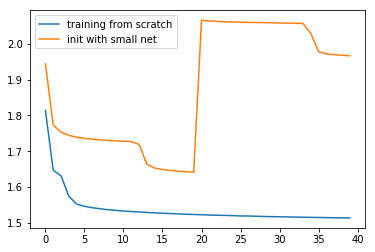

In [38]:
plt.plot(losses_big, label='training from scratch')
plt.plot(np.append(losses_small,losses_big_2), label='init with small net')
plt.legend()

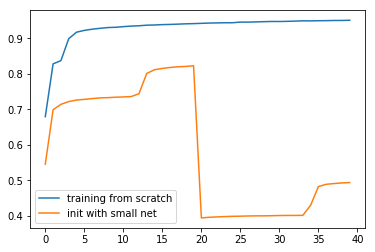

In [39]:
plt.plot(training_acc_big, label='training from scratch')
plt.plot(np.append(training_acc_small, training_acc_big_2), label='init with small net')
plt.legend()

In [40]:
test_acc = test(small_net, test_loader)
print(test_acc)

0.4940286624203822


In [41]:
test_acc = test(big_net, test_loader)
print(test_acc)

0.9334195859872612
